# DINOv2를 사용한 이미지 검색

Meta Research에서 2023년 4월에 출시한 DINOv2는 컴퓨터 비전 모델을 훈련하는 자체 지도 방법(self-supervised method)을 구현합니다.

DINOv2는 레이블 없이 1억 4천만 개의 이미지를 사용하여 훈련되었습니다. DINOv2에 의해 생성된 임베딩은 분류, 이미지 검색, 세분화 및 깊이 추정에 사용할 수 있습니다. 그렇긴 하지만, Meta Research는 세분화 및 깊이 추정을 위한 헤드를 공개하지 않았습니다.

이 가이드에서는 DINOv2를 사용하여 이미지-이미지 검색 시스템을 구축하는 방법에 대해 설명합니다.

1. 이미지 폴더 불러오기
2. 각 이미지에 대한 임베딩 계산
3. faiss 인덱스에 모든 임베딩을 저장합니다.
4. 이미지에 대한 인덱스를 검색하는 논리를 빌드합니다.

이 데모에서는 Roboflow Universe에서 사용할 수 있는 COCO128 데이터 세트에 대한 이미지 검색 엔진을 구축합니다. 먼저 Roboflow에서 데이터 세트를 다운로드하고 검색 엔진을 구축할 train 폴더의 모든 파일 목록을 만들어 보겠습니다.

In [1]:
!pip install roboflow faiss-gpu supervision -q

In [2]:
import roboflow
import os

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("popular-benchmarks").project("mit-indoor-scene-recognition")
dataset = project.version(5).download("folder")

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


In [3]:
cwd = os.getcwd()

# train
ROOT_DIR = os.path.join(cwd, "MIT-Indoor-Scene-Recognition-5/train")

labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

In [4]:
print(list(files)[0], labels[list(files)[0]])

/home/user/res/image-retrieval-db/MIT-Indoor-Scene-Recognition-5/train/jewelleryshop/store5_50__jpg.rf.207a29e97c84800e83148a8ce4f773c7.jpg jewelleryshop


## 종속성 가져오기 및 모델 로드

다음으로 프로젝트에 필요한 나머지 종속성을 가져오고 DINOv2 모델을 로드해 보겠습니다. 이 가이드에 dinov2_vits14 가장 작은 모델로 작업합니다. 이 모델을 DINOv2 GitHub 저장소의 모든 체크포인트로 교체할 수 있습니다.

In [5]:
import faiss
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import cv2
import json
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import supervision as sv

In [6]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14")

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

dinov2_vits14.to(device)

Using cache found in /home/user/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


## Prepare Images and Index 이미지 및 색인 준비

image-to-image 검색 엔진을 구축하려면 다음을 저장해야 합니다.

1. 관련 이미지를 쿼리하는 데 사용하기 위해 데이터 세트에 있는 각 이미지의 임베딩 표현 및;
2. faiss 데이터 저장소의 임베딩 인덱스를 파일 이름에 매핑하는 인덱스입니다(faiss는 값을 인덱스와 연결하므로 이러한 인덱스를 파일 이름에 다시 매핑하는 방법이 필요함).

인덱스를 작성하기 전에 이미지를 DINOv2 ViT 모델이 이해할 수 있는 형식으로 변환해야 합니다. 아래의 transform_image 가지 방법과 load_image 가지 방법으로 이 작업을 수행합니다.

그런 다음 지정된 폴더의 각 파일을 반복하고 각 파일에 대한 임베딩을 계산하는 함수를 정의합니다. 이러한 임베딩은 이미지를 찾기 위해 쿼리할 faiss 벡터 인덱스에 저장됩니다.

In [7]:
transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])

def load_image(img: str) -> torch.Tensor:
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

In [8]:
def create_index(files: list, method: str = "l2", dims: int = 384) -> tuple:
    if method == "l2":
        index = faiss.IndexFlatL2(dims)
    elif method == "ip":
        index = faiss.IndexFlatIP(dims)
        
    all_embeddings = {}
    
    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        embeddings = dinov2_vits14(load_image(file).to(device))

        embedding = embeddings[0].cpu().numpy()

        all_embeddings[file] = np.array(embedding).reshape(1, -1).tolist()

        index.add(np.array(embedding).reshape(1, -1))

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    faiss.write_index(index, "data.bin")

    return index, all_embeddings

In [9]:
data_index, all_embeddings = create_index(files, method="ip", dims=1024)

  0%|          | 0/10885 [00:00<?, ?it/s]

## 인덱스 검색 준비 (Prepare to Search the Index)

아래에서는 벡터 인덱스에서 입력 이미지를 임베딩하는 것과 가장 유사한 임베딩이 있는 k 이미지를 검색하는 함수를 정의합니다. 즉, 이 함수는 인덱스에서 관련 이미지를 검색하고 인덱스에서 해당 위치를 반환합니다.

In [10]:
def search_index(index, embeddings: list, k: int = 3) -> list:
    D, I = index.search(np.array(embeddings[0].reshape(1, -1)), k)

    return I[0], D[0]

Input image:


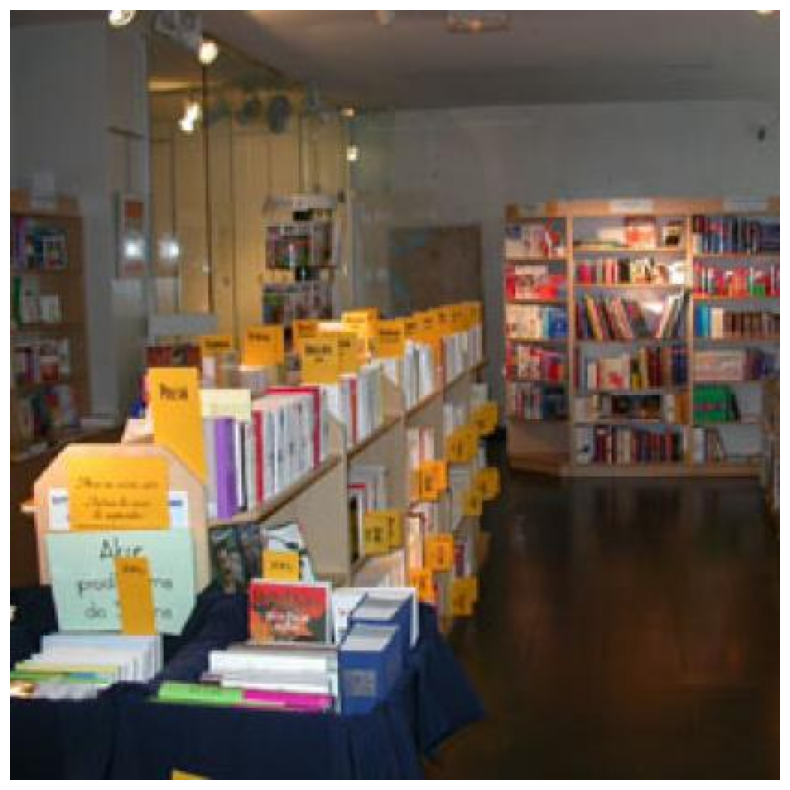

In [11]:
search_file = "MIT-Indoor-Scene-Recognition-5/train/bookstore/4002_Librairie1_jpg.rf.d1210d1c27745cff85294527c4419de5.jpg"

img = cv2.resize(cv2.imread(search_file), (416, 416)) 

print("Input image:")

%matplotlib inline
sv.plot_image(image=img, size=(10, 10))

********************

Image 0 (2127.685302734375): /home/user/res/image-retrieval-db/MIT-Indoor-Scene-Recognition-5/train/bookstore/4002_Librairie1_jpg.rf.d1210d1c27745cff85294527c4419de5.jpg


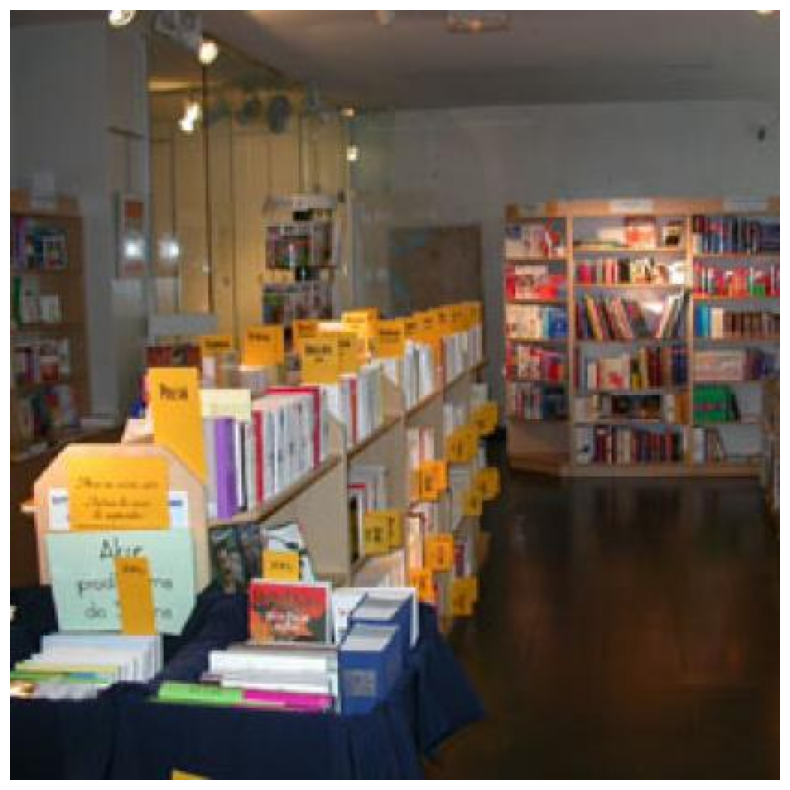


Image 1 (1852.03564453125): /home/user/res/image-retrieval-db/MIT-Indoor-Scene-Recognition-5/train/bookstore/bookstore_47_17_altavista_jpg.rf.2197aec8227e28633b34e25f5a9f794f.jpg


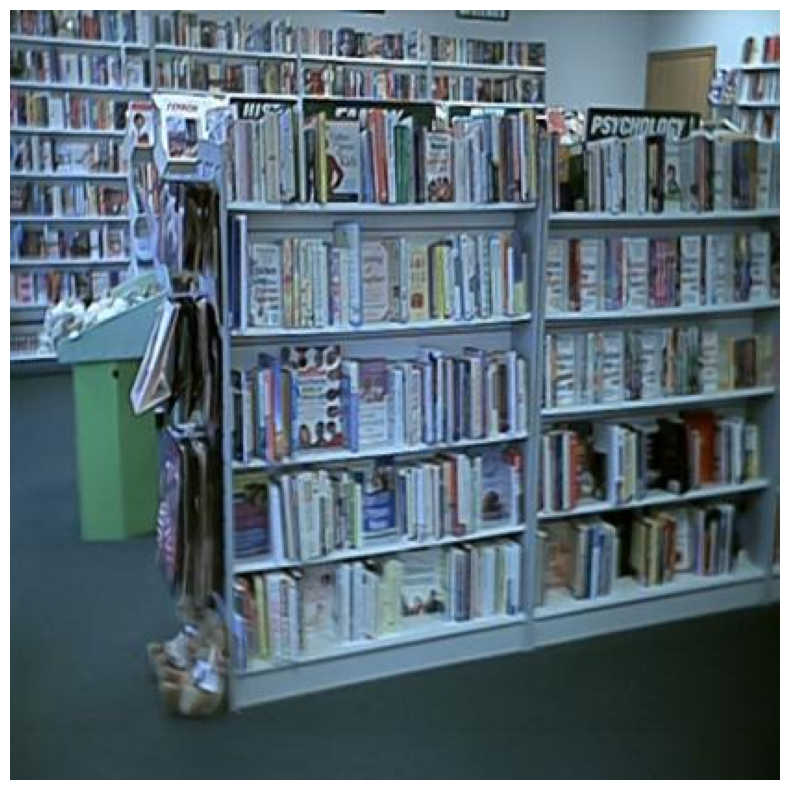


Image 2 (1801.99951171875): /home/user/res/image-retrieval-db/MIT-Indoor-Scene-Recognition-5/train/library/BIB_bibliothek_jpg.rf.619603934f43555a75dd5693d829a938.jpg


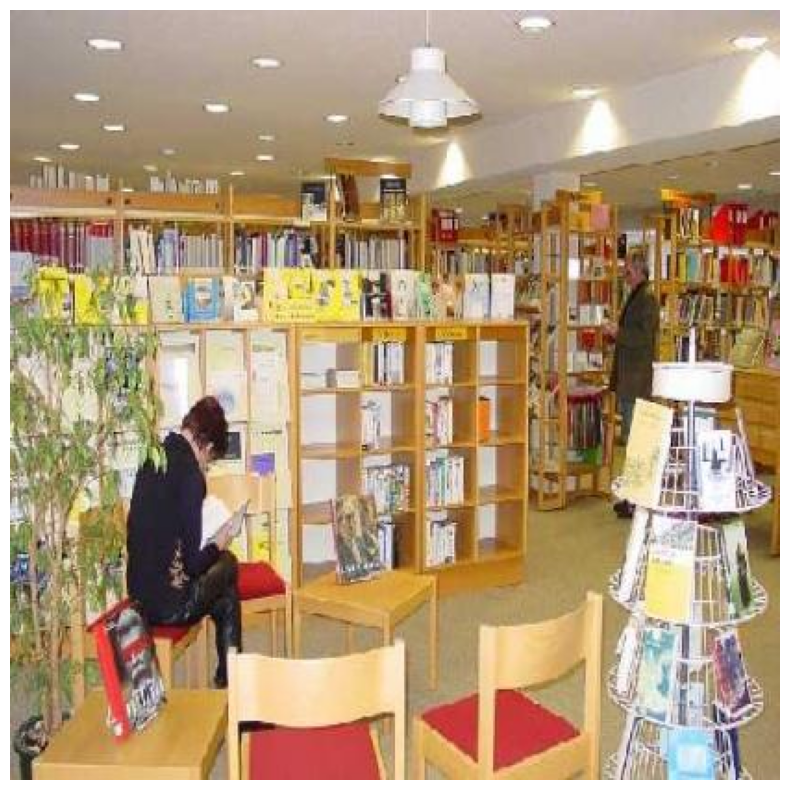

In [12]:
print("*" * 20)

with torch.no_grad():
    embedding = dinov2_vits14(load_image(search_file).to(device))

    indices, scores = search_index(data_index, np.array(embedding[0].cpu()).reshape(1, -1))

    for i, (index, score) in enumerate(zip(indices, scores)):
        print()
        print(f"Image {i} ({score}): {list(files)[index]}")
        img = cv2.resize(cv2.imread(list(files)[index]), (416, 416)) 
        %matplotlib inline
        sv.plot_image(image=img, size=(10, 10))

## Evaluation 평가

In [13]:
def load_evaluation_data(root_dir):
    labels = {}
    for split in ['valid', 'test']:
        split_dir = os.path.join(root_dir, split)
        for folder in os.listdir(split_dir):
            for file in os.listdir(os.path.join(split_dir, folder)):
                if file.endswith(".jpg"):
                    full_name = os.path.join(split_dir, folder, file)
                    labels[full_name] = folder
    return labels

In [14]:
eval_root_dir = "MIT-Indoor-Scene-Recognition-5"
eval_labels = load_evaluation_data(eval_root_dir)
eval_files = list(eval_labels.keys())
eval_gts = list(eval_labels.values())

In [15]:
from sklearn.metrics import accuracy_score, classification_report

y_true = []
y_pred = []

with torch.no_grad():
    for file in tqdm(eval_files):
        
        embedding = dinov2_vits14(load_image(file).to(device))

        indices, scores = search_index(data_index, np.array(embedding[0].cpu()).reshape(1, -1))

        true_label = eval_labels[file]
        pred_label = labels[list(files)[indices[0]]]

        # print(true_label, pred_label)
        
        y_true.append(true_label)
        y_pred.append(pred_label)

# 평가 메트릭 계산
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

  0%|          | 0/4686 [00:00<?, ?it/s]


Accuracy: 0.5243

Classification Report:
                     precision    recall  f1-score   support

     airport_inside       0.96      0.84      0.89       280
          artstudio       1.00      0.75      0.86        99
         auditorium       0.93      0.16      0.27       167
             bakery       1.00      0.25      0.41       401
                bar       0.00      0.00      0.00       603
           bathroom       0.00      0.00      0.00       197
            bedroom       0.00      0.00      0.00       653
          bookstore       0.91      0.78      0.84       141
            bowling       1.00      1.00      1.00        60
             buffet       0.72      0.96      0.83        27
             casino       0.97      0.98      0.98       143
      children_room       0.07      0.52      0.12        29
      church_inside       0.97      0.98      0.97        58
          classroom       0.90      0.93      0.91        28
           cloister       0.95      0.98  

In [16]:
# dinos-l2: {Accuracy: 0.4827, f1: 0.48}
# dinos-ip: {Accuracy: 0.4866, f1: 0.49}
# dinos-ip: {Accuracy: 0.5243, f1: 0.52}